# Many with astrocytes

Let $A_i$ denote an $N_z$ by $N_z$ matrix encoding the synaptic connections controlled by astrocyte $i$.

$$
\begin{eqnarray*}
    \dot{z_i} & = & z_i ( (\lambda_i + \mathrm{i}) + b_i |z_i|^2) + \sum_k W_{ik} z_k \\
    \dot{a_i} & = & \theta \left(\left(\frac{1}{N_a} \sum_k a_k\right) - a_i\right) + \varphi \left( \sum_k B_{ik} |z_k| \right) - \kappa a_i \\
    \dot{W} & = & \left\{\alpha\left( I_{N_z} - \mathbf{z} \bar{\mathbf{z}}^\top \right)\right\}_? - \beta\left( \sum_k a_k A^{(k)} \right) \circ W
\end{eqnarray*}
$$

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

In [2]:
Nz = 20
Na = 20

# Hopf oscillator characteristics
l = np.random.randn( Nz )
# TODO Should the Lyopunov exponent vary across oscillators?
b = -0.1 + np.random.randn( Nz ) * 1.j

In [63]:
alpha = 0.1 # 0.001 # 0.1
beta = 0.001 # 0.0005 # 0.0001

theta = 0.01 # 0.00001 # 0.0001
phi = 0.1
kappa = 1.

In [4]:
A = []
# for i in range( Na ):
#     A.append( np.random.exponential( size = (Nz, Nz) ) )
for i in range( Na ):
    A_cur = np.zeros( (Nz, Nz) )
    A_cur[i, :] = 1.
    A.append( A_cur )
    
# B = np.zeros( (Na, Nz) )
# for i in range( Na ):
#     for k in range( Nz ):
#         B[i, k] = np.sum( A[i][:, k] )
B = 3 * np.eye( Na )
# B = np.random.exponential( size = (Na, Nz) )

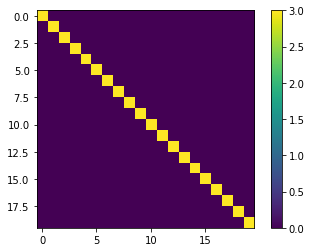

In [5]:
plt.imshow( B )
plt.clim( 0, 3 )
plt.colorbar()

In [6]:
t_input_start = 1e3
t_input_end = 1.1e3 # 2e3 # 1.1e3
input_channel = 10
input_frequency = 1.
input_magnitude = 100.

In [64]:
def deriv( t, y ):
    
    z = y[:Nz]
    a = y[Nz:(Nz+Na)]
    W = np.reshape( y[(Nz+Na):], (Nz, Nz) )
    
    z_dot = np.zeros( z.shape[0], dtype = np.complex )
    for i in range( z_dot.shape[0] ):
        z_dot[i] = z[i] * ( ( l[i] + 1.j ) + b[i] * z[i] * np.conj( z[i] ) )
        
#         if t >= t_input_start and t < t_input_end:
#             if i == input_channel:
#                 z_dot[i] = z_dot[i] + input_magnitude * np.sin( 2 * np.pi * input_frequency * t )
        
        for k in range( z_dot.shape[0] ):
#             if k == i:
#                 continue
#             z_dot[i] += W[i, k] * np.real( z[k] )
            z_dot[i] += W[i, k] * z[k]
    
    a_dot = np.zeros( a.shape[0], dtype = np.complex )
    a_bar = (1. / a.shape[0]) * np.sum( a )
    for i in range( a_dot.shape[0] ):
        a_dot[i] = theta * (a_bar - a[i])
        for k in range( z_dot.shape[0] ):
            a_dot[i] += phi * B[i, k] * np.abs( z[k] )
    a_dot -= kappa * a
    
#     W_dot = alpha * ( np.eye( Nz ) - np.outer( np.real( z ), np.real( z ) ) )
    W_dot = alpha * ( np.eye( Nz ) - np.outer( z, np.conj( z ) ) )
#     W_dot = np.zeros( (Nz, Nz), dtype = np.complex )
    for k in range( a_dot.shape[0] ):
        W_dot -= beta * ( a[k] * A[k] ) * W
    
    y_dot = np.zeros( y.shape[0], dtype = np.complex )
    y_dot[:Nz] = z_dot
    y_dot[Nz:(Nz+Na)] = a_dot
    y_dot[(Nz+Na):] = W_dot.flatten()
    
    return y_dot

In [8]:
t_span = [0, 6e3]
t_eval = np.arange( t_span[0], t_span[-1], 1e-2 )

In [9]:
# TODO Randomize the z0 in an intelligent way
z0 = np.zeros( (Nz,), dtype = np.complex )
for i in range( z0.shape[0] ):
    z0[i] = 0.01 + 0.j
    
# TODO Randomize the a0 in an intelligent way
a0 = np.random.exponential( size = (Na,) )
    
W0 = np.random.randn( Nz, Nz ) + np.random.randn( Nz, Nz ) * 1.j

In [10]:
y0 = np.zeros( (Nz + Na + Nz*Nz,), dtype = np.complex )
y0[:Nz] = z0
y0[Nz:(Nz+Na)] = a0
y0[(Nz+Na):] = W0.flatten()

In [65]:
sol = scipy.integrate.solve_ivp( deriv, t_span, y0,
                                 t_eval = t_eval )  # 'BDF'

In [66]:
t_star = sol.t
y_star = sol.y

z_star = y_star[:Nz, :]
a_star = y_star[Nz:(Nz+Na), :]
W_star = np.reshape( y_star[(Nz+Na):, :], (Nz, Nz, y_star.shape[1]) )

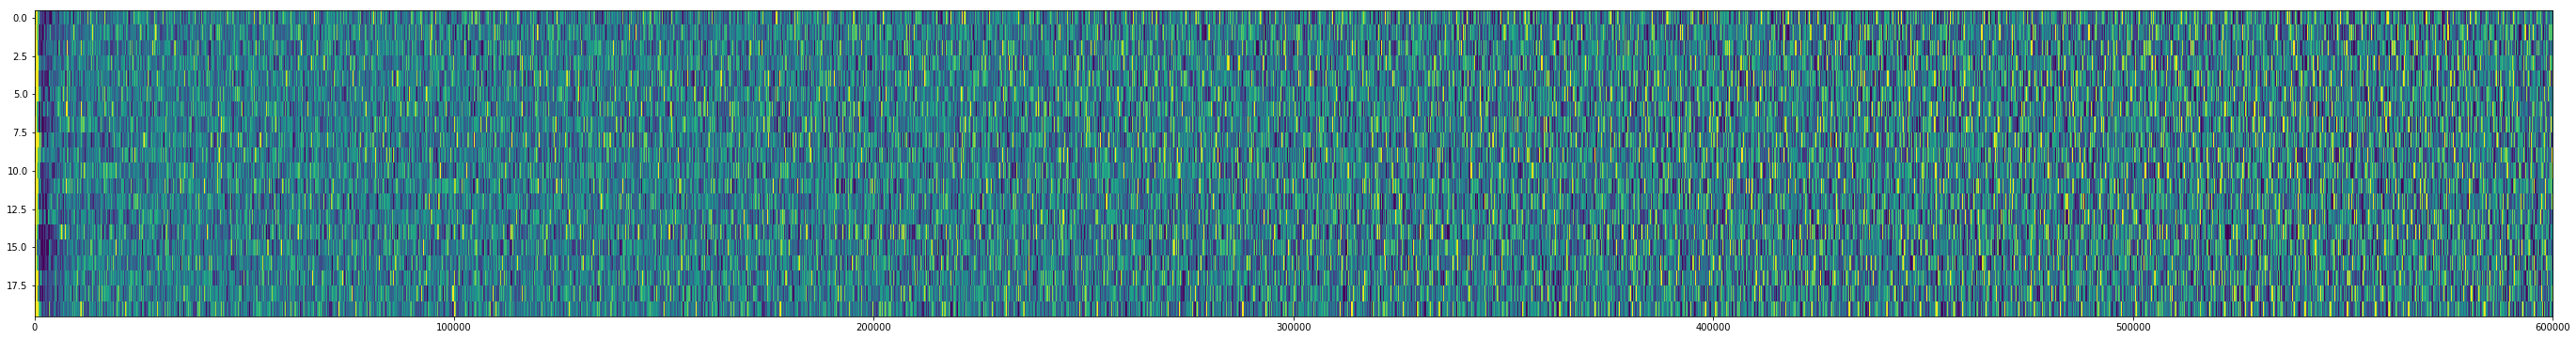

In [67]:
plt.figure( figsize = (48, 6) )
plt.imshow( np.real( a_star ), aspect = 'auto',
            vmin = np.quantile( np.real( a_star ), 0.01 ),
            vmax = np.quantile( np.real( a_star ), 0.99 ) )

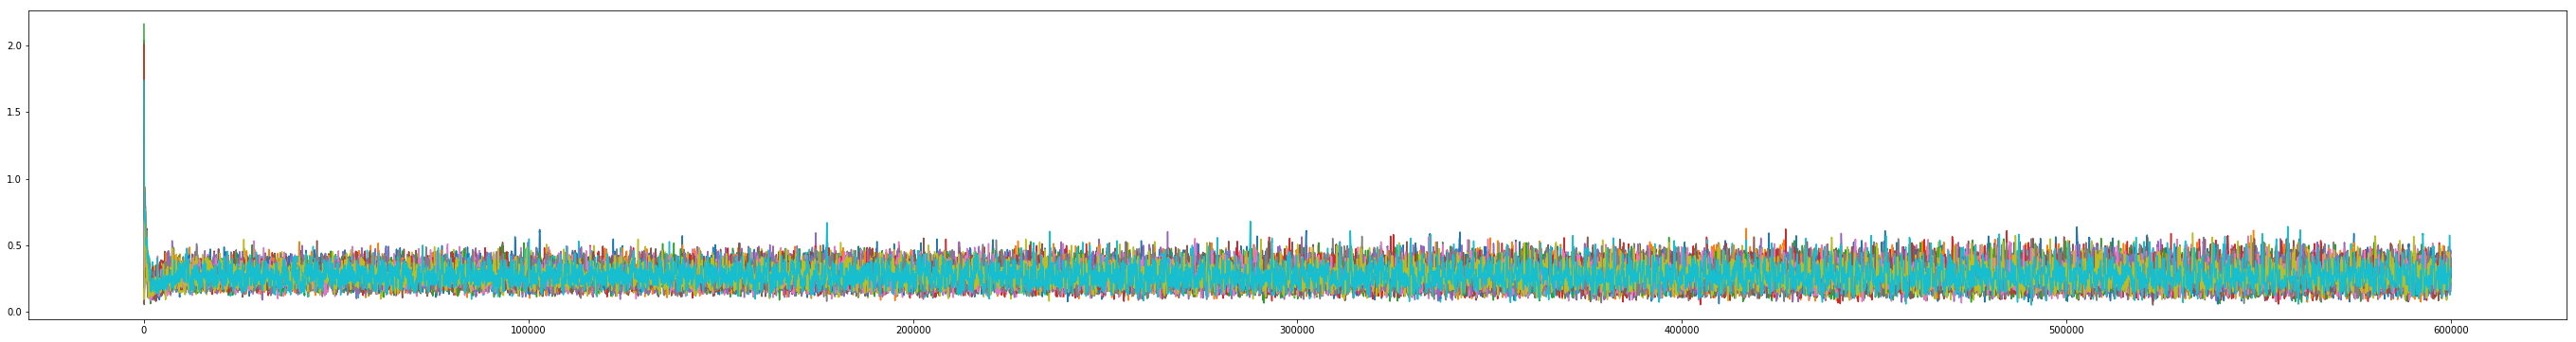

In [73]:
plt.figure( figsize = (48, 6) )
plt.plot( np.real( a_star ).T )
# plt.ylim( 0, 1. )
plt.show()

(2000, 2100)

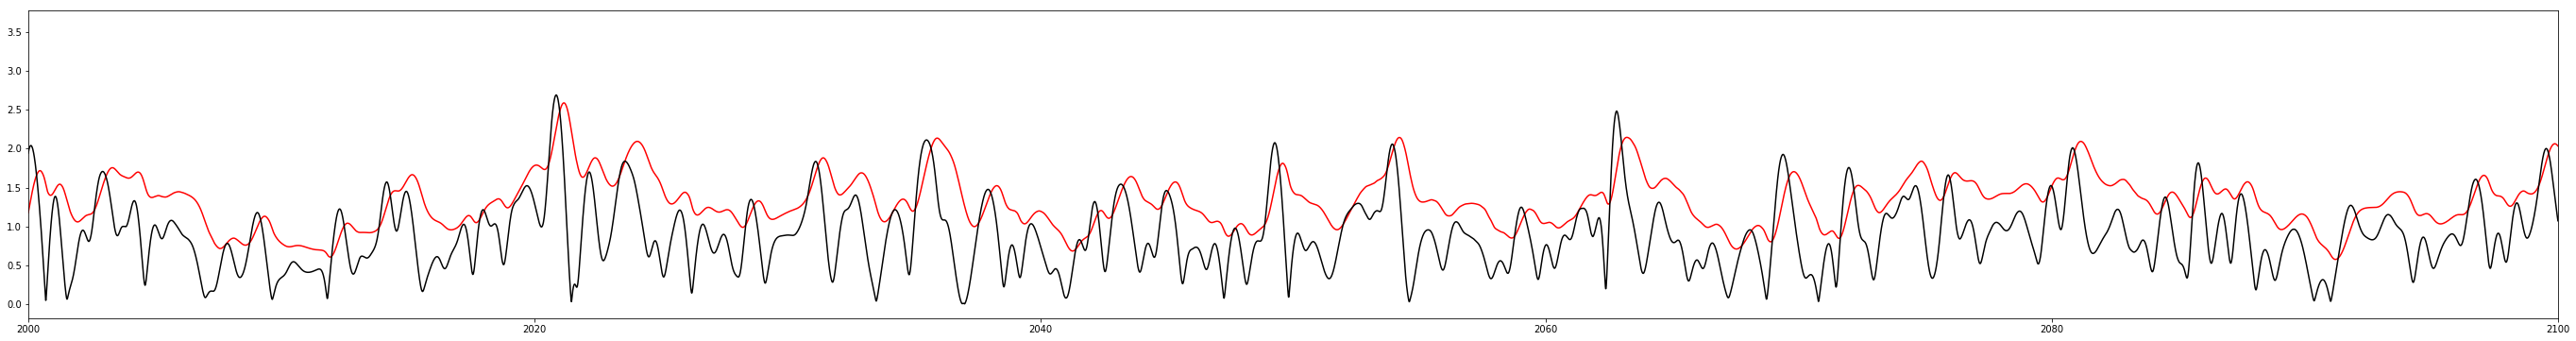

In [76]:
plt.figure( figsize = (48, 6) )
plt.plot( t_star, 5 * np.real( a_star[0, :] ), 'r-' )
plt.plot( t_star, np.abs( z_star[0, :] ), 'k-' )
plt.xlim( 2000, 2100 )

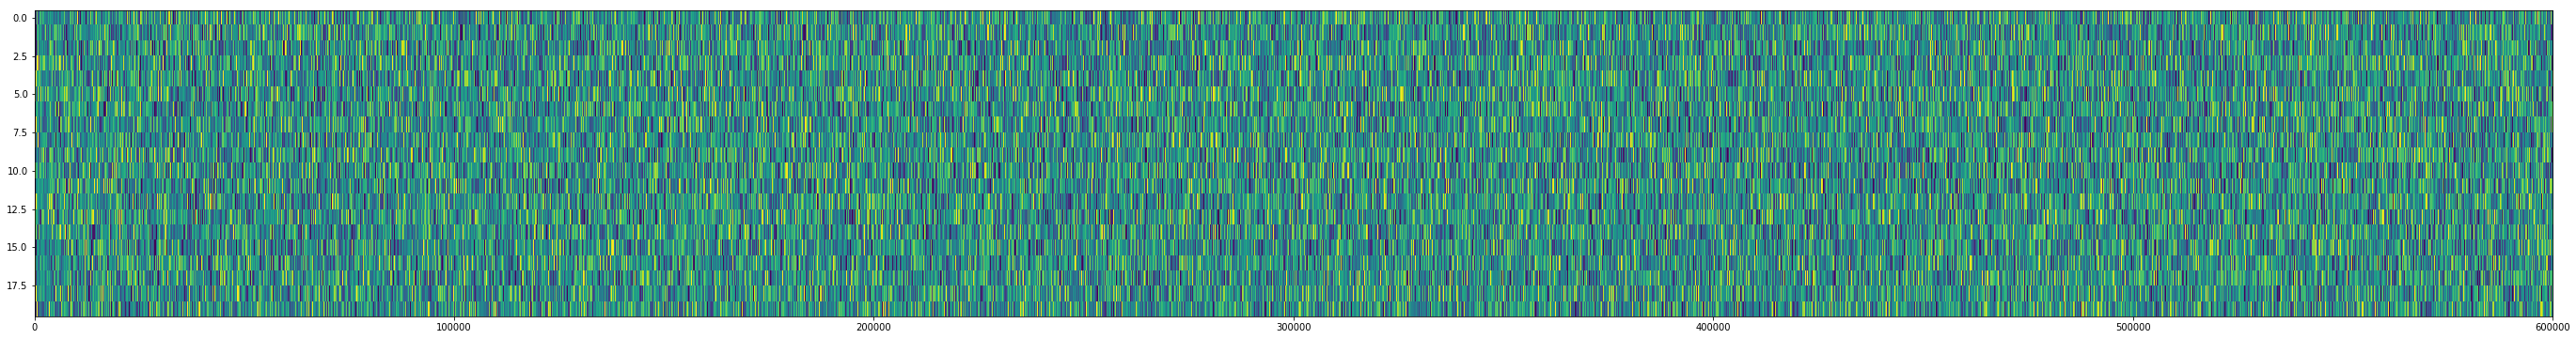

In [70]:
plt.figure( figsize = (48, 6) )
plt.imshow( np.real( z_star ), aspect = 'auto',
            vmin = np.quantile( np.real( z_star ), 0.01 ),
            vmax = np.quantile( np.real( z_star ), 0.99 ) )

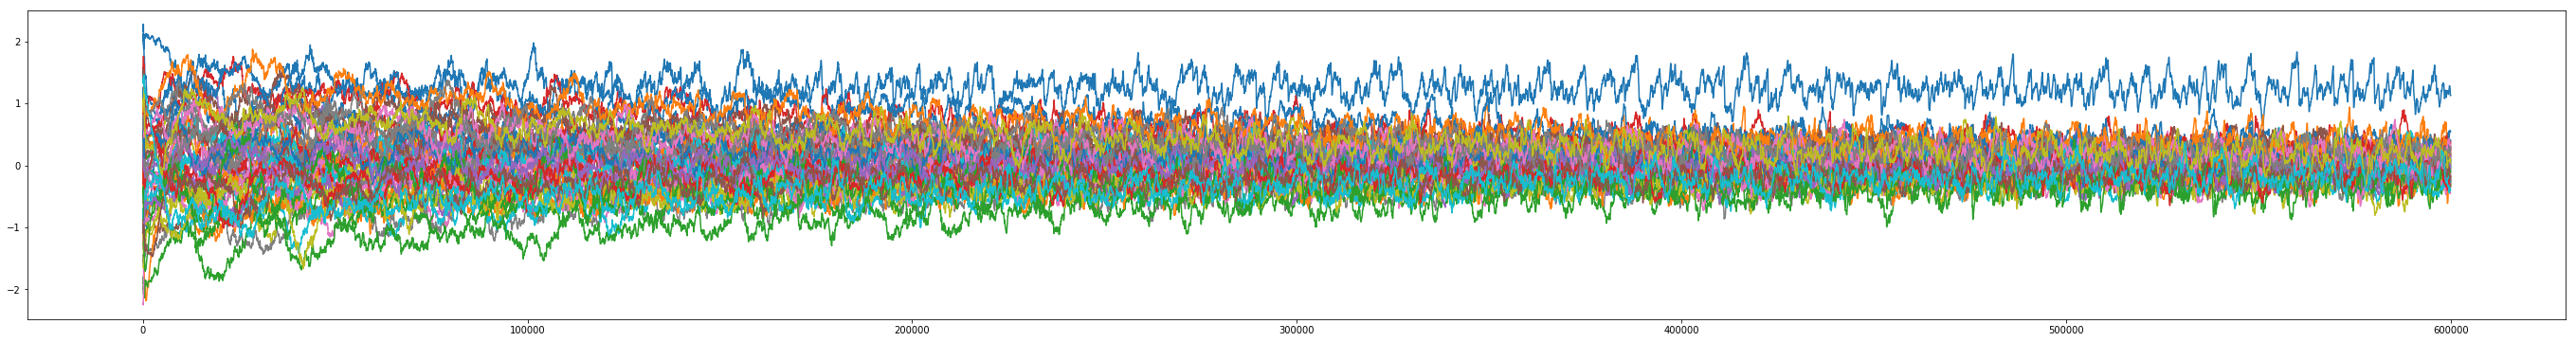

In [71]:
plt.figure( figsize = (48, 6) )
plt.plot( np.real( y_star[(Nz+Na):(Nz+Na+50), :] ).T )
plt.show()

In [ ]:
plt.figure( figsize = (48, 6) )
plt.plot( np.unwrap( np.angle( y_star[(Nz+Na):, :] ) ).T )
plt.show()

In [17]:
import scipy.signal

In [18]:
import concurrent.futures
import time

In [77]:
coherence_window = 512
coherence_window_step = 128
coherence_nfft = 512
coherence_f_min = 0.0
coherence_f_max = 0.1

coherence_starts = np.arange( 0, z_star.shape[1] - coherence_window, coherence_window_step )

In [78]:
def coherence_procedure( i ):
    
    start = time.time()
    
    print( 'Starting row {0}'.format( i ) )
    
    ret = np.zeros( (Nz, coherence_starts.shape[0]) )
    
    for j in range( Nz ):
        for i_start, cur_start in enumerate( coherence_starts ):
            cur_end = cur_start + coherence_window
            cur_data_i = np.real( z_star[i, cur_start:cur_end] )
            cur_data_j = np.real( z_star[j, cur_start:cur_end] )

            f, Cxy = scipy.signal.coherence( cur_data_i, cur_data_j, nfft = coherence_nfft )
            ret[j, i_start] = np.mean( Cxy[(f >= coherence_f_min) & (f < coherence_f_max)] )
    
    end = time.time()
    time_delta = end - start
    
    return ret, time_delta

In [79]:
run_outputs = []
run_times = []

start = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
    for cur_output, cur_time in executor.map( coherence_procedure, range( Nz ) ):
        run_outputs.append( cur_output )
        run_times.append( cur_time )
end = time.time()

print( 'Done.' )

Starting row 3
Starting row 2
Starting row 1
Starting row 0
Starting row 4
Starting row 5
Starting row 6
Starting row 7
Starting row 8
Starting row 9
Starting row 10
Starting row 11
Starting row 12
Starting row 13
Starting row 14
Starting row 15
Starting row 16
Starting row 17
Starting row 18
Starting row 19
Done.


In [80]:
print( 'Total execution time: {0:0.3f}'.format( sum( run_times ) ) )
print( 'Total wall time: {0:0.3f}'.format( end - start ) )
print( 'Time saved: {0:0.3f}'.format( sum( run_times ) - (end - start) ) )

Total execution time: 1648.888
Total wall time: 416.356
Time saved: 1232.533


In [81]:
coherence_traces = np.zeros( (Nz, Nz, coherence_starts.shape[0],) )
for i in range( Nz ):
    coherence_traces[i, :, :] = run_outputs[i]

In [82]:
coherence_centers = coherence_starts + coherence_window / 2

In [83]:
coherence_traces_list = []
coherence_pair_list = []
for i in range( Nz ):
    for j in range( i+1, Nz ):
        coherence_traces_list.append( coherence_traces[i, j, :] )
        coherence_pair_list.append( (i, j) )

coherence_traces_linear = np.zeros( (len( coherence_traces_list ), coherence_traces_list[0].shape[0]) )
for i, trace in enumerate( coherence_traces_list ):
    coherence_traces_linear[i, :] = trace

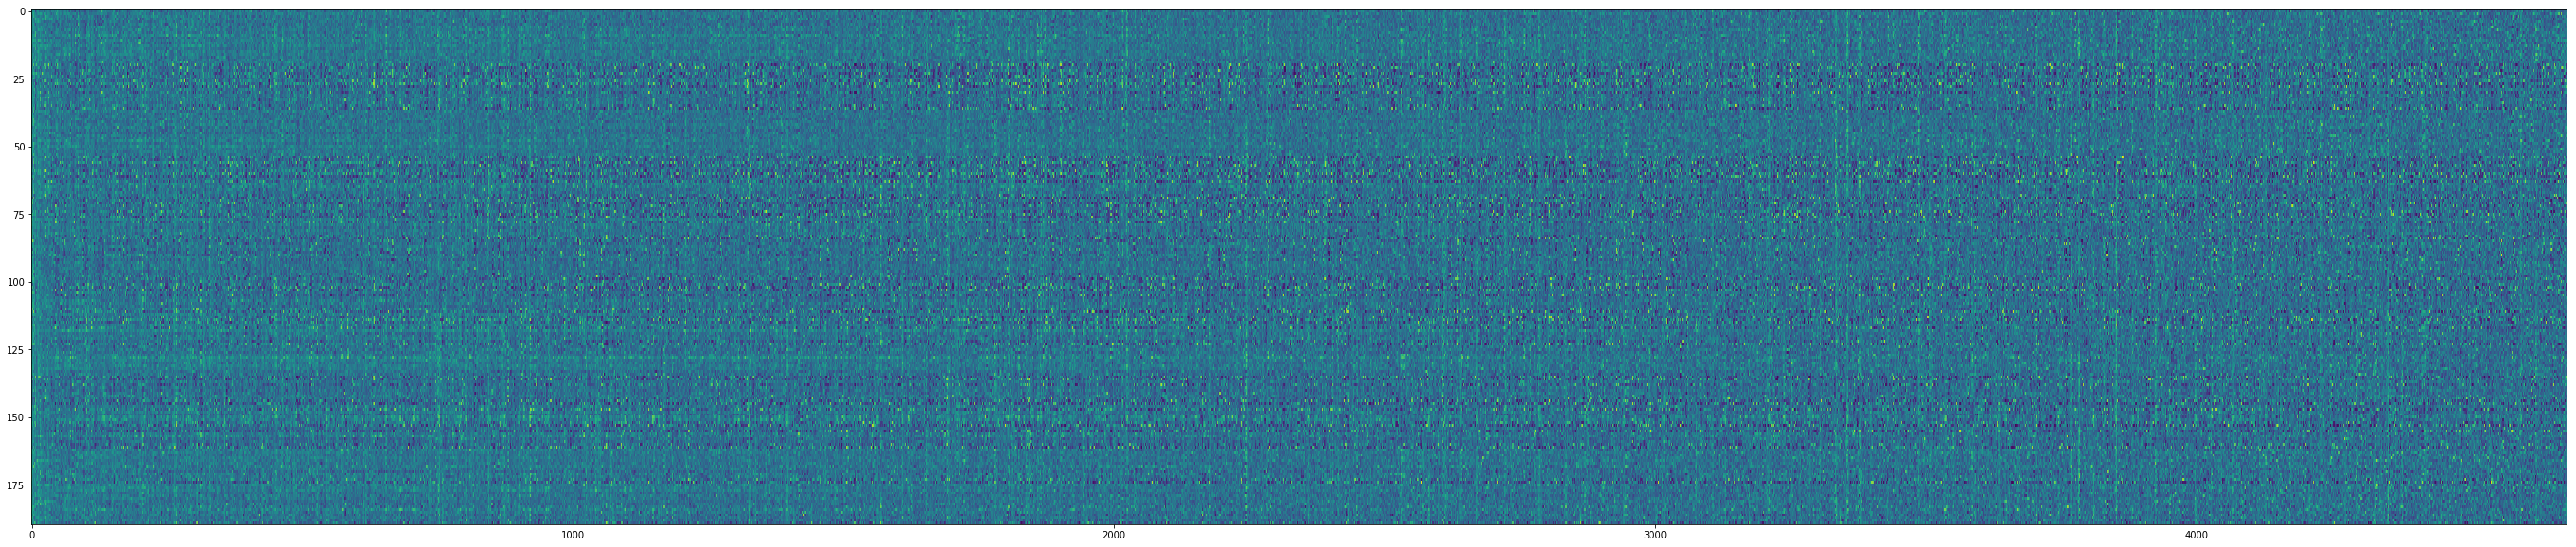

In [84]:
# i_coherence_trunc = np.where( (coherence_centers / 1e2) >= 2000 )[0][0]

plt.figure( figsize = (48, 10) )
plt.imshow( coherence_traces_linear, aspect = 'auto' )

sample_start = np.min( np.where( (coherence_centers / 100) >= t_input_start )[0] )
sample_end = np.max( np.where( (coherence_centers / 100) < t_input_end )[0] )
yl = plt.ylim()
# plt.plot( sample_start * np.array( [1, 1] ), yl, 'w--' )
# plt.plot( sample_end * np.array( [1, 1] ), yl, 'w--' )

plt.clim( 0, 1 )